In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from realism.realism_utils import make_orderbook_for_analysis, MID_PRICE_CUTOFF
from util.plotting import liquidity_telemetry as lt

In [3]:
def get_delays_and_profits(paths):
    output = None
    slave_ids = {}
    master_ids = {}
    for path in paths:
        master_profit = None
        delays = {}
        slave_ids[path] = []
        for file in os.listdir(path):
            if 'HerdMasterAgent' in file:
                try:
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    master_profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    m_id = int(file.split('HerdMasterAgent')[1].split('.')[0])
                    master_ids[path] = m_id
                except (IndexError, KeyError):
                    continue                
            if 'HerdSlaveAgent' in file:
                try:
                    s_id = int(file.split('HerdSlaveAgent')[1].split('.')[0])
                    slave_ids[path].append(s_id)
                    df = pd.read_pickle(os.path.join(path,file), compression='bz2')
                    delay = df.loc[df.EventType == 'DELAY', 'Event'].values[0]
                    profit = df.loc[df.EventType == 'ENDING_CASH', 'Event'].values[0] - df.loc[df.EventType == 'STARTING_CASH', 'Event'].values[0]
                    delays[delay] = profit
                except (IndexError, KeyError):
                    continue
        x, y = np.asarray(sorted(delays.items()))[:, 0], np.asarray(sorted(delays.items()))[:, 1]
        temp = pd.DataFrame({'DELAY': x, 'SLAVE_PROFIT': y})
        temp['MASTER_PROFIT'] = master_profit
        temp['SIMULATION'] = path
        if output is None:
            output = temp
        else:
            output = output.append(temp)
    output['PERCENT'] = output.SLAVE_PROFIT/output.MASTER_PROFIT
    output = output.sort_values(by='DELAY').reset_index(drop=True)
    return output, slave_ids, master_ids

In [4]:
def get_herd_impact(paths, slaves):
    output = None
    for path in paths:
        df = pd.read_pickle(os.path.join(path,'EXCHANGE_AGENT.bz2'), compression='bz2')
        df = df[df.EventType == 'ORDER_ACCEPTED']
        df.reset_index(inplace=True)
        temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
        temp['EventTime'] = df.EventTime
        t = temp[temp.agent_id.isin(slaves[path])][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
        t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
        t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
        t['SIMULATION'] = path
        t['tot_vol'] = t1.tot_vol
        
        output = t if output is None else output.append(t)
    return output

Configuration 1

In [ ]:
# end-time 12:00:00
# master-window 1e+9
# slave-min-delay 1e+1 
# slave-max-delay 1e+8
# 1 master
# 40 slaves
# limit orders

# Master Strategy
# if ask < r_f:
#     buy = True
#     p = ask - adjust_int
#     size = self.getHoldings(self.symbol)*(-1) if self.getHoldings(self.symbol) < 0 else self.size
#     if p >= r_f:
#         return
# elif bid > r_f:
#     buy = False
#     p = bid + adjust_int
#     size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#     if p <= r_f:
#         return
# if self.currentTime+delta < self.mkt_close:
#     self.placeLimitOrder(self.symbol, size, buy, p)

# Slave Strategy
# if order['is_buy_order']:
#     quantity = order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])



PATHS = ["log/herd01_2_5_hour_0/", "log/herd01_2_5_hour_1/", "log/herd01_2_5_hour_2/", "log/herd01_2_5_hour_3/", 
         "log/herd01_2_5_hour_4/", "log/herd01_2_5_hour_5/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [ ]:
t = get_herd_impact(PATHS, slave_ids)

In [ ]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100

In [ ]:
#t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Configuration 2

In [ ]:
# Changed slave strategy to this.


# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(self.symbol) * (-1) if self.getHoldings(self.symbol) < 0 else order['quantity']
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])


PATHS = ["log/herd01_2_5_hour_0_s/", "log/herd01_2_5_hour_1_s/", "log/herd01_2_5_hour_2_s/", "log/herd01_2_5_hour_3_s/", 
         "log/herd01_2_5_hour_4_s/", "log/herd01_2_5_hour_5_s/", "log/herd01_2_5_hour_6_s/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.1, 0.2], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config. 3

In [ ]:
# Changed limit orders to market orders and moved the message from accepted to placed
# changed to master-window 5e+9


PATHS = ["log/herd01_2_5_hour_1_t/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//3
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.75, -1, -2], xmin=[xmin, xmin, xmin, xmin], xmax=[xmax, xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 4.

In [ ]:
# end-time 12:00:00
# changed to master-window 5e+9
# slave-min-delay 1e+1 
# changed to slave-max-delay 1e+9
# 1 master
# changed to 60 slaves
# changed to 100 momentum agents
# back to limit orders

# Master Strategy
# if ask < r_f:
#     buy = True
#     p = ask - adjust_int
#     size = self.getHoldings(self.symbol)*(-1) if self.getHoldings(self.symbol) < 0 else self.size
#     if p >= r_f:
#         return
# elif bid > r_f:
#     buy = False
#     p = bid + adjust_int
#     size = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else self.size
#     if p <= r_f:
#         return
# if self.currentTime+delta < self.mkt_close:
#     self.placeLimitOrder(self.symbol, size, buy, p)

# Slave Strategy
# if order['is_buy_order']:
#     quantity = self.getHoldings(symbol) * (-1) if self.getHoldings(symbol) < 0 else quantity
# else:
#     quantity = self.getHoldings(self.symbol) if self.getHoldings(self.symbol) > 0 else order['quantity']
# self.placeLimitOrder(order['symbol'], quantity, order['is_buy_order'], order['limit_price'])



PATHS = ["log/herd01_2_5_hour_1_z/", "log/herd01_2_5_hour_2_z/", "log/herd01_2_5_hour_3_z/", 
         "log/herd01_2_5_hour_4_z/", "log/herd01_2_5_hour_5_z/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.5, 0.75, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 5

In [ ]:
# I try to make it a bit more realistic with the herd representing a small volume of the total transactions.
# changed to master-window 3e+9 
# changed to slave-max-delay 1e+9
# changed order size from 5 to 2
# 1 master
# changed to 40 slaves
# changed to 300 momentum agents
# limit orders

# Master Strategy unchanged

# Slave Strategy unchanged


PATHS = ["log/herd01_2_5_hour_1_x/", "log/herd01_2_5_hour_2_x/", "log/herd01_2_5_hour_3_x/", 
         "log/herd01_2_5_hour_4_x/", "log/herd01_2_5_hour_5_x/", "log/herd01_2_5_hour_6_x/", 
         "log/herd01_2_5_hour_7_x/"]

df, slave_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//30
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.75, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [ ]:
t = get_herd_impact(PATHS, slave_ids)

In [ ]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100
t.reset_index(inplace=True)
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

Config 6

In [ ]:
# Herd02 config

PATHS = []
for file in os.listdir('log'):
    if 'herd02' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

In [ ]:
df['g'] = df.index//120
temp = df.groupby('g').agg(['mean', 'std'])
temp

In [ ]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0, 0.5, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [ ]:
temp[temp.agent_id == master_ids[PATHS[0]]][['EventTime', 'quantity']].set_index('EventTime')[560:].head(50)

In [ ]:
df = pd.read_pickle(os.path.join(path,'EXCHANGE_AGENT.bz2'), compression='bz2')
df = df[df.EventType == 'ORDER_ACCEPTED']
df.reset_index(inplace=True)
temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
temp['EventTime'] = df.EventTime
t = temp[temp.agent_id.isin(slaves[path])][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
t.rename(columns={'quantity': 'slave_vol'}, inplace=True)
t1 = temp[temp.is_buy_order == True][['EventTime', 'quantity']].set_index('EventTime').resample('5T').sum()
t1.rename(columns={"quantity": 'tot_vol'}, inplace=True)
t['SIMULATION'] = path
t['tot_vol'] = t1.tot_vol

output = t if output is None else output.append(t)


In [ ]:
t = get_herd_impact(PATHS, slave_ids)
t

In [ ]:
t['PERCENT'] = t.slave_vol/t.tot_vol*100
t.reset_index(inplace=True)

In [ ]:
temp = t.sort_values(by='EventTime').groupby('EventTime').agg(['mean', 'std']).reset_index()
temp

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume')
plt.errorbar(temp[1:].EventTime, temp[1:].slave_vol['mean'], yerr=temp[1:].slave_vol['std'], ecolor='red')  
plt.errorbar(temp[1:].EventTime, temp[1:].tot_vol['mean'], yerr=temp[1:].tot_vol['std'], ecolor='red')  
plt.show()

In [ ]:
plt.xlabel('Time')
plt.ylabel('Volume percentage of herd')
plt.errorbar(temp.EventTime, temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()

In [ ]:
fun = pd.read_pickle(os.path.join(PATHS[10],'fundamental_ABM.bz2'), compression='bz2')

In [ ]:
df = pd.read_pickle(os.path.join(PATHS[10],'EXCHANGE_AGENT.bz2'), compression='bz2')
df = df[df.EventType == 'ORDER_EXECUTED']
df.reset_index(inplace=True)

In [ ]:
temp = pd.DataFrame.from_dict(df[['EventTime', 'Event']].Event.to_dict()).T
temp['EventTime'] = df.EventTime

In [ ]:
temp = temp.drop_duplicates(subset=['EventTime'])[['EventTime', 'fill_price']].reset_index(drop=True).set_index('EventTime').astype('int')
temp

In [ ]:
(temp.resample('1T').mean()/100).plot()

In [ ]:
(fun.resample('1T').mean()/100).plot()

In [5]:
# Herd03 config

PATHS = []
for file in os.listdir('log'):
    if 'herd03' in file:
        PATHS.append(f'log/{file}')

df, slave_ids, master_ids = get_delays_and_profits(PATHS)
df

,DELAY,SLAVE_PROFIT,MASTER_PROFIT,SIMULATION,PERCENT
0,286883.0,1234.0,6800,log/herd03_seed_422396446,0.181471
1,342187.0,8186.0,7072,log/herd03_seed_3842306364,1.157523
2,428872.0,5448.0,5555,log/herd03_seed_1345499493,0.980738
3,850660.0,3344.0,7072,log/herd03_seed_3842306364,0.472851
4,1003303.0,9093.0,9971,log/herd03_seed_602957303,0.911945
...,...,...,...,...,...
5995,998611239.0,1695.0,6065,log/herd03_seed_2876537340,0.279472
5996,998738060.0,5361.0,7940,log/herd03_seed_1923688040,0.675189
5997,998973671.0,2626.0,4764,log/herd03_seed_1261063143,0.551217
5998,999444814.0,8783.0,6512,log/herd03_seed_1768615473,1.348741


In [13]:
df['g'] = df.index//300
temp = df.groupby('g').agg(['mean', 'std'])
temp

DELAY               SLAVE_PROFIT              MASTER_PROFIT  \
            mean           std         mean          std          mean   
g                                                                        
0   2.599193e+07  1.497188e+07  9457.496667  5778.447932   9390.543333   
1   7.482449e+07  1.418810e+07  8971.156667  4933.225749   8969.966667   
2   1.237401e+08  1.472173e+07  8680.096667  4941.580985   8983.770000   
3   1.765181e+08  1.430960e+07  8897.710000  5517.329115   9313.080000   
4   2.239471e+08  1.459970e+07  8916.420000  4986.964285   9494.933333   
5   2.772314e+08  1.485603e+07  8849.510000  4914.496772   9679.826667   
6   3.308337e+08  1.567792e+07  8173.880000  4581.363629   9346.656667   
7   3.809213e+08  1.420441e+07  7806.470000  4648.578468   8911.983333   
8   4.282417e+08  1.397103e+07  8138.876667  5012.520901   9368.830000   
9   4.748018e+08  1.233859e+07  8366.826667  5644.717292   9406.496667   
10  5.237470e+08  1.624924e+07  7119.570000  4422.693576   8880.450000   
11  5.794474e+08  1.542855e+07  6802.776667  3617.596336   8823.633333   
12  6.296114e+08  1.369760e+07  6903.563333  4774.717785   8990.036667   
13  6.802370e+08  1.480414e+07  6822.043333  4241.086362   9053.670000   
14  7.294241e+08  1.261331e+07  6324.733333  3735.629622   8863.393333   
15  7.745879e+08  1.380868e+07  6529.426667  4623.596408   9019.036667   
16  8.258070e+08  1.542038e+07  6616.430000  4576.658562   9233.403333   
17  8.771747e+08  1.293181e+07  6988.800000  5137.023542   9323.496667   
18  9.256565e+08  1.473236e+07  6877.746667  4985.046206   9593.343333   
19  9.748717e+08  1.428819e+07  6740.380000  5537.769514   9986.850000   

                  PERCENT            
            std      mean       std  
g                                    
0   5341.543147  1.014528  0.324281  
1   4100.095029  0.999235  0.308430  
2   4682.379673  0.973812  0.329942  
3   5176.908698  0.955516  0.383197  
4   4969.716060  0.955494  0.321042  
5   4958.589690  0.924929  0.290633  
6   4907.671782  0.886583  0.311998  
7   4681.188495  0.892054  0.406446  
8   4752.195611  0.862762  0.299817  
9   4852.364519  0.897599  0.482215  
10  4143.496237  0.808658  0.368183  
11  3668.873450  0.772290  0.313708  
12  5010.610723  0.770382  0.384129  
13  4074.939808  0.740740  0.284066  
14  4159.098342  0.714143  0.303871  
15  4470.089540  0.717423  0.361516  
16  4571.399770  0.694278  0.317925  
17  4142.323165  0.729346  0.410760  
18  4574.674731  0.704226  0.408053  
19  6281.402821  0.663835  0.358614

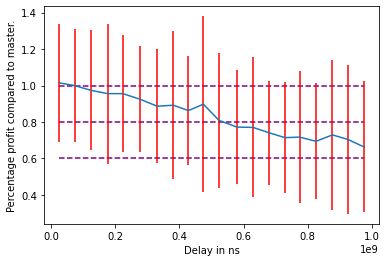

In [14]:
plt.xlabel('Delay in ns')
plt.ylabel('Percentage profit compared to master.')
xmin, xmax= temp.DELAY['mean'].min(), temp.DELAY['mean'].max()
plt.hlines(y=[0.6, 0.8, 1], xmin=[xmin, xmin, xmin], xmax=[xmax, xmax, xmax], colors='purple', linestyles='dashed')
plt.errorbar(temp.DELAY['mean'], temp.PERCENT['mean'], yerr=temp.PERCENT['std'], ecolor='red')  
plt.show()